In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
import pandas as pd
from collections import defaultdict

from load_data import DATA_DIR, TRANSFORMS, P53_CLASS_NAMES, \
    convert_presence_probs_to_status_probs
from resnet import ResNetModel, ResNetModelDoubleBinary
# from resnet_patch import ResNetModelDoubleBinary as ResNetModelDoubleBinaryPatch
from pl_clam import CLAM_MB, CLAM_db

P53_CLASS_CODES = ["WT", "OE", "NM", "DC"]

BOLERO_DIR = os.path.join(DATA_DIR, '..', 'BOLERO')
PATHXL_DIR = os.path.join(DATA_DIR, '..', 'p53_consensus_study')

BASE_DIR = {
    'test': DATA_DIR,
    'bolero': BOLERO_DIR,
    'pathxl': PATHXL_DIR
}

RESULTS_DIR = os.path.join(DATA_DIR, '..', '..', 'results')
os.makedirs(RESULTS_DIR, exist_ok=True)

bag_latent_paths = {
    "test":   os.path.join(BASE_DIR["test"], "bag_latents_gs256_retccl__backup.pt"),
    "bolero": os.path.join(BASE_DIR["bolero"], "bag_latents_gs256_retccl.pt"),
    "pathxl": os.path.join(BASE_DIR["pathxl"], "bag_latents_gs256_retccl.pt"),
}

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print("Device: {}".format(device))

color_dict = {
    "r": '#DA4C4C', # Red
    "o": '#E57439', # Orange
    "y": '#EDB732', # Yellow
    "g": '#479A5F', # Green
    "lb": '#5BC5DB', # Light blue
    "b": '#5387DD', # Blue
    "p": '#7D54B2', # Purple
    "pi": '#E87B9F', # Pink
#  '#229487', # Dark green/Turquoise
#  '#C565C7', # Lilac
    "r_p": '#E89393', # Pale red
    "o_p": '#EFAB88', # Pale orange
    "y_p": '#F4D384', # Pale yellow
    "g_p": '#90C29F', # Pale green
    "lb_p":'#9CDCE9', # Pale light blue
    "b_p": '#98B7EA', # Pale blue
    "p_p": "#B198D0", # Pale purple
}
colors = list(color_dict.values())

C:\Users\321lu\AppData\Local\Temp\ipykernel_33100\386516407.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Device: cuda
Device: cuda
Device: cuda


# Load Models

In [3]:
MODELS_DIR = os.path.join(DATA_DIR, '..', '..', 'models')

In [4]:
# fb: full biopsy, db: double binary, gs: grid spacing
model_kwargs = {
    "CLAM":     {"model_class": CLAM_MB, "gs": 256},
    "CLAM_db":  {"model_class": CLAM_db, "gs": 256},
    "CLAM_m":   {"model_class": CLAM_MB, "gs": 256},
    "CLAM_db_m":{"model_class": CLAM_db, "gs": 256},
}
for name in ["fb_db", "fb"]:
    # for size in [256, 1024]:
    #     model_name = f"{name}_size{size}"
    #     model_kwargs[model_name] = {"size": size}
    for spacing in [2, 4, 8, 16, 32, 64, 128, 256]:
        if "db" not in name and spacing == 2: # Skipped this one because it's too slow
            continue
        model_name = f"{name}_spacing{spacing}"
        model_kwargs[model_name] = {"spacing": spacing}

for model_name in model_kwargs:
    if "fb_db" in model_name:
        model_kwargs[model_name]["model_class"] = ResNetModelDoubleBinary
    elif "fb" in model_name:
        model_kwargs[model_name]["model_class"] = ResNetModel
    checkpoint_dir = os.path.join(MODELS_DIR, model_name)
    os.makedirs(checkpoint_dir, exist_ok=True)
    model_kwargs[model_name]["checkpoint_paths"] = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith(".ckpt")]

def load_model(model_class, checkpoint_path):
    if "CLAM" in model_class.__name__: # For some reason pl can't load these models with load_from_checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        # model = model_class(**checkpoint["model_kwargs"])
        model = model_class()
        model.load_state_dict(checkpoint["state_dict"])
    else:
        model = model_class.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.to(device)
    return model

In [5]:
# Print how many checkpoints we have for each model
for model_name in model_kwargs:
    print(f"{model_name}: {len(model_kwargs[model_name]['checkpoint_paths'])} checkpoints")

CLAM: 5 checkpoints
CLAM_db: 5 checkpoints
CLAM_m: 5 checkpoints
CLAM_db_m: 5 checkpoints
fb_db_spacing2: 5 checkpoints
fb_db_spacing4: 5 checkpoints
fb_db_spacing8: 4 checkpoints
fb_db_spacing16: 5 checkpoints
fb_db_spacing32: 5 checkpoints
fb_db_spacing64: 5 checkpoints
fb_db_spacing128: 5 checkpoints
fb_db_spacing256: 5 checkpoints
fb_spacing4: 5 checkpoints
fb_spacing8: 5 checkpoints
fb_spacing16: 5 checkpoints
fb_spacing32: 5 checkpoints
fb_spacing64: 5 checkpoints
fb_spacing128: 5 checkpoints
fb_spacing256: 5 checkpoints


# Inference functions

In [6]:
def load_img(img_name, data_name):
    img_path = os.path.join(BASE_DIR[data_name], 'biopsies', f"{img_name}.png")
    img = plt.imread(img_path) # (H, W, C) float32
    return img
    
def load_patch_latents(img_name, data_name, bag_latents):
    if data_name == "test":
        return bag_latents[img_name].squeeze(1) # (N, 2048)
    elif data_name == "bolero":
        slide_name, biopsy_name = tuple(img_name.split("_"))
        slide_latents = bag_latents[int(slide_name)] # (n_biopsies, N, 2048)
        return slide_latents[int(biopsy_name)+1] # (N, 2048)
    elif data_name == "pathxl":
        return bag_latents[img_name].squeeze(1) # (N, 2048)


def call_constant_size(model, img_name, data_name, size, **kwargs):
    img = load_img(img_name, data_name)
    img = torch.nn.functional.interpolate(torch.tensor(img).permute(2, 0, 1).unsqueeze(0), size=(size, size), mode='bilinear')
    img = TRANSFORMS['normalize'](img)
    with torch.no_grad():
        return model(img.to(device)).cpu().detach().numpy()

def call_constant_spacing(model, img_name, data_name, spacing, **kwargs):
    img = load_img(img_name, data_name)
    h = img.shape[0] // spacing
    w = img.shape[1] // spacing
    img = torch.nn.functional.interpolate(torch.tensor(img).permute(2, 0, 1).unsqueeze(0), size=(h, w), mode='bilinear')
    img = TRANSFORMS['normalize'](img)
    with torch.no_grad():
        return model(img.to(device)).cpu().detach().numpy()

def call_CLAM(model, img_name, data_name, bag_latents, **kwargs):
    patch_latents = load_patch_latents(img_name, data_name, bag_latents).unsqueeze(0)
    with torch.no_grad():
        logits, Y_prob, Y_hat, A_raw, results_dict = model(patch_latents.to(device))
        return Y_prob.cpu().detach().numpy(), A_raw.cpu().detach().numpy()
    

for model_name in model_kwargs:
    if "size" in model_kwargs[model_name]:
        model_kwargs[model_name]["call"] = call_constant_size
    elif "spacing" in model_kwargs[model_name]:
        model_kwargs[model_name]["call"] = call_constant_spacing
    elif "CLAM" in model_name:
        model_kwargs[model_name]["call"] = call_CLAM
    else:
        raise ValueError(f"Unknown call type for {model_name}")

# Eval functions

In [7]:
def get_img_names(data_name='test'):
    if data_name.startswith("test+pathxl"):
        return get_img_names("test") + get_img_names("pathxl")
    if data_name == "test":
        return pd.read_csv(os.path.join(BASE_DIR[data_name], 'test.csv'))["id"].tolist()
    return [img_path.split('.')[0] for img_path in os.listdir(os.path.join(BASE_DIR[data_name], 'biopsies'))]

def get_results(model, mdl_kwargs, data_name='test', bag_latents=None):
    img_names = get_img_names(data_name)
    results = {}
    for img_name in tqdm(img_names):
        results[img_name] = mdl_kwargs["call"](model, img_name, data_name, bag_latents=bag_latents, **mdl_kwargs)
    return results

def save_results(results, model_name, data_name, checkpoint_name):
    results_dir = os.path.join(RESULTS_DIR, model_name)
    os.makedirs(results_dir, exist_ok=True)
    results_path = os.path.join(results_dir, f"{data_name}_{checkpoint_name}.pt")
    torch.save(results, results_path)

In [502]:
for data_name in ["test", "bolero", "pathxl"]:
    print(f"\nRUNNING {data_name.upper()}")
    bag_latents = torch.load(bag_latent_paths[data_name], map_location=device)
    for model_name, mdl_kwargs in model_kwargs.items():
        for i, checkpoint_path in enumerate(mdl_kwargs["checkpoint_paths"][:]):
            checkpoint_name = os.path.basename(checkpoint_path).replace(".ckpt", "")
            results_path = os.path.join(RESULTS_DIR, model_name, f"{data_name}_{checkpoint_name}.pt")

            if os.path.exists(results_path):
                print(f"Already done {model_name}")
                continue
            print(f"Running {model_name} {i}")
            model = load_model(mdl_kwargs["model_class"], checkpoint_path)
            results = get_results(model, mdl_kwargs, data_name=data_name, bag_latents=bag_latents)
            save_results(results, model_name, data_name=data_name, checkpoint_name=checkpoint_name)


RUNNING TEST
Already done CLAM
Already done CLAM
Already done CLAM
Already done CLAM
Already done CLAM
Already done CLAM_db
Already done CLAM_db
Already done CLAM_db
Already done CLAM_db
Already done CLAM_db
Already done CLAM_m
Already done CLAM_m
Already done CLAM_m
Already done CLAM_m
Already done CLAM_m
Already done CLAM_db_m
Already done CLAM_db_m
Already done CLAM_db_m
Already done CLAM_db_m
Already done CLAM_db_m
Already done fb_db_spacing2
Already done fb_db_spacing2
Already done fb_db_spacing2
Already done fb_db_spacing2
Already done fb_db_spacing2
Already done fb_db_spacing4
Already done fb_db_spacing4
Already done fb_db_spacing4
Already done fb_db_spacing4
Already done fb_db_spacing4
Already done fb_db_spacing8
Already done fb_db_spacing8
Already done fb_db_spacing8
Already done fb_db_spacing8
Already done fb_db_spacing16
Already done fb_db_spacing16
Already done fb_db_spacing16
Already done fb_db_spacing16
Already done fb_db_spacing16
Already done fb_db_spacing32
Already do

# Get Metrics
Load results and labels

In [8]:
"""
fb_db   has a dict like idx: shape (1,2) with the two mutation probabilities
fb      has a dict like idx: shape (1,4) with the four class probabilities
CLAM_db has a dict like idx: tuple of: (
            shape (1,2) with the two mutation probabilities,
            shape (2, n_patches) Attention map 
    )
CLAM    has a dict like idx: tuple of: (
            shape (1,4) with the four class probabilities,
            shape (2, n_patches) Attention map 
        )
"""
model_type_result_keys = {
    "fb_db": ["presence_probs"],
    "fb": ["status_probs"],
    "CLAM_db": ["presence_probs", "A_raw"],
    "CLAM": ["status_probs", "A_raw"],
}
def get_result_keys(model_name):
    for key in model_type_result_keys: # The order is important
        if key in model_name:
            return model_type_result_keys[key]

def load_results(model_name, data_name):
    if data_name.startswith("test+pathxl"):
        results = defaultdict(lambda: defaultdict(dict))
        for data_name in ["test", "pathxl"]:
            results_data = load_results(model_name, data_name)
            for key in results_data:
                results[key].update(results_data[key])
        return results

    results_dir = os.path.join(RESULTS_DIR, model_name)
    results = defaultdict(lambda: defaultdict(dict))
    for i, checkpoint_name in enumerate([f for f in os.listdir(results_dir) if f.startswith(data_name)]):
        results_path = os.path.join(results_dir, checkpoint_name)
        result_content = torch.load(results_path)
        checkpoint_name = checkpoint_name.replace(f"{data_name}_", "").replace(".pt", "")
        if "CLAM_db" in model_name:
            for img_name, (presence_probs, A_raw) in result_content.items():
                results["presence_probs"][img_name][checkpoint_name] = presence_probs
                results["status_probs"][img_name][checkpoint_name] = convert_presence_probs_to_status_probs(torch.tensor(presence_probs)).numpy()
                results["A_raw"][img_name][checkpoint_name] = A_raw
        elif "CLAM" in model_name:
            for img_name, (status_probs, A_raw) in result_content.items():
                results["status_probs"][img_name][checkpoint_name] = status_probs
                results["A_raw"][img_name][checkpoint_name] = A_raw
        elif "fb_db" in model_name:
            for img_name, presence_probs in result_content.items():
                results["presence_probs"][img_name][checkpoint_name] = presence_probs
                results["status_probs"][img_name][checkpoint_name] = convert_presence_probs_to_status_probs(torch.tensor(presence_probs)).numpy()
        elif "fb" in model_name:
            for img_name, status_probs in result_content.items():
                # results["status_probs"][img_name][checkpoint_name] = status_probs
                results["status_probs"][img_name][checkpoint_name] = torch.nn.functional.softmax(torch.tensor(status_probs), dim=1).numpy()
        else:
            raise ValueError(f"Unsupported model type {model_name}")
    return results

def get_labels(data_name):
    if data_name == "test":
        return pd.read_csv(os.path.join(BASE_DIR[data_name], 'test.csv')).set_index("id").to_dict(orient='dict')['label']
    elif data_name == "bolero":
        labels = pd.read_csv(os.path.join(BASE_DIR[data_name], 'P53_BOLERO_T.csv'))
        labels = labels.sort_values(by="Case ID")
        labels = labels.reset_index(drop=True)
        # Map GS to {1:0, 2:1, 3:2, 4:4} where 4 is unknown
        labels["GS"] = labels["GS"].map({1:0, 2:1, 3:2, 4:4})
        # Only keep GS column
        labels = labels[["GS"]].to_dict(orient='dict')["GS"]
        return labels
    elif data_name.startswith("pathxl"):
        labels = pd.read_csv(os.path.join(BASE_DIR["pathxl"], 'labels.csv'))
        # idx is id column and biopsy_nr column separated by _
        labels["idx"] = labels["id"].astype(str) + "_" + labels["biopsy_nr"].astype(str)
        labels = labels.set_index("idx")
        # Sort by id primarily and biopsy_nr secondarily
        labels = labels.sort_values(by=["id", "biopsy_nr"])
        # Map label
        mapping = {"WT":0, "Overexpression":1, "Null":2, "Double clones":3}
        labels["label"] = labels["label"].map(mapping)
        if data_name == "pathxl": # Filter out any concordance % < 75
            labels = labels[labels["concordance %"] >= 75]
        elif data_name == "pathxl-100":
            labels = labels[labels["concordance %"] == 100]
        labels = labels[["label"]].to_dict(orient='dict')["label"]
        return labels
    elif data_name == "test+pathxl":
        labels = get_labels("test")
        labels.update(get_labels("pathxl"))
        return labels
    elif data_name == "test+pathxl-100":
        labels = get_labels("test")
        labels.update(get_labels("pathxl-100"))
        return labels
    
# load_results("fb_spacing4", "test")["status_probs"]
# get_labels("test+pathxl-100")

metrics functions

In [9]:
# Functions to get accuracy, confusion matrices, roc curves, area under roc curve
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.metrics import auc as calc_auc

def get_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def get_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

def get_roc_curves(y_true, y_score, multi_class=True):
    if multi_class:
        # Get fpr, tpr for each of the four classes
        fpr, tpr = {}, {}
        for i in range(4):
            if np.sum(y_true == i) == 0:
                continue
            fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
        return fpr, tpr
    else:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        return fpr, tpr

def get_auc(fpr, tpr, multi_class=True):
    if multi_class:
        # Get auc for each of the four classes
        auc = {}
        for i in range(4):
            if i in fpr:
                auc[i] = calc_auc(fpr[i], tpr[i])
        return auc
    else:
        return calc_auc(fpr, tpr)

def calculate_metrics(y_true, y_pred, y_score, multi_class=True):
    accuracy = get_accuracy(y_true, y_pred)
    conf_matrix = get_confusion_matrix(y_true, y_pred)
    fpr, tpr = get_roc_curves(y_true, y_score, multi_class=multi_class)
    auc = get_auc(fpr, tpr, multi_class=multi_class)
    if multi_class:
        mean_auc = np.nanmean(list(auc.values()))
    else:
        mean_auc = auc
    return accuracy, conf_matrix, fpr, tpr, auc, mean_auc

calculate metrics

In [10]:
model_results = defaultdict(lambda: defaultdict(dict))

In [11]:
for data_name in ["test", "test+pathxl-100"]:
    print(f"\nMETRICS FOR {data_name.upper()}")
    labels = get_labels(data_name)
    # Take the intersection of the image names (some images might be missing in the labels file or the input data)
    img_names_input = get_img_names(data_name)
    img_names_label = list(labels.keys())
    img_names = list(set(img_names_input).intersection(img_names_label))
    for model_name in tqdm(model_kwargs):
        # Check if we have results for this model
        results_dir = os.path.join(RESULTS_DIR, model_name)
        if (not os.path.exists(results_dir) or not any([f.startswith(data_name) for f in os.listdir(results_dir)])) and not data_name.startswith("test+pathxl"):
            continue

        results = load_results(model_name, data_name)
        for checkpoint_name in list(results["status_probs"].values())[0].keys():
            status_probs = np.array([results["status_probs"][img_name][checkpoint_name][0] for img_name in img_names]) # (N, 4)
            y_pred = np.argmax(status_probs, axis=1)
            y_true = np.array([labels[img_name] for img_name in img_names])
            accuracy, conf_matrix, fpr, tpr, auc, mean_auc = calculate_metrics(y_true, y_pred, status_probs)

            # Also calculate these if we compare WT to Mutated
            # Sum the mutated classes 1,2,3
            status_probs_mutated = np.array([np.sum(results["status_probs"][img_name][checkpoint_name][0][1:]) for img_name in img_names]) # (N,)
            y_pred_mutated = status_probs_mutated > 0.5
            y_true_mutated = y_true > 0
            accuracy_m, conf_matrix_m, fpr_m, tpr_m, auc_m,_ = calculate_metrics(y_true_mutated, y_pred_mutated, status_probs_mutated.reshape(-1, 1), multi_class=False)
            # # Just don't count doubleclones
            # status_probs_mutated = np.array([results["status_probs"][img_name][checkpoint_name][0][:2] for img_name in img_names]) # (N, 3)
            # y_pred = np.argmax(status_probs, axis=1)
            # y_true = np.array([labels[img_name] for img_name in img_names])
            # accuracy, conf_matrix, fpr, tpr, auc, mean_auc = calculate_metrics(y_true, y_pred, status_probs)

            model_results[data_name][model_name][checkpoint_name] = {
                "accuracy": accuracy,
                "conf_matrix": conf_matrix,
                "fpr": fpr,
                "tpr": tpr,
                "auc": auc,
                "mean_auc": mean_auc,
                "accuracy_m": accuracy_m,
                "conf_matrix_m": conf_matrix_m,
                "fpr_m": fpr_m,
                "tpr_m": tpr_m,
                "auc_m": auc_m
            }

def get_status_probs_for_bolero(results, slide_names, checkpoint_name):
    biopsy_status_probs = defaultdict(list)
    biopsy_pred_confidence = defaultdict(list)
    for img_name in results["status_probs"]:
        slide_name = int(img_name.split("_")[0])
        biopsy_status_probs[slide_name].append(results["status_probs"][img_name][checkpoint_name][0][:3]) # Ignore the double clones class for BOLERO
        # Special case if doubleclones scores highest: add that to the highest out of OE and NM
        if np.argmax(results["status_probs"][img_name][checkpoint_name][0]) == 3:
            biopsy_status_probs[slide_name][-1][np.argmax(biopsy_status_probs[slide_name][-1][1:3])+1] += results["status_probs"][img_name][checkpoint_name][0][3]
        biopsy_pred_confidence[slide_name].append(np.max(results["status_probs"][img_name][checkpoint_name][0][1:])) # Confidence in the presence of a mutation
    # Take the vote of the most confident biopsy
    status_probs = np.array([biopsy_status_probs[slide_name][np.argmax(biopsy_pred_confidence[slide_name])] for slide_name in slide_names]) # (N, 3)
    return status_probs

# Metrics for BOLERO is slightly different because we only have slide labels and have to take the max vote of the biopsies
print("\nMETRICS FOR BOLERO")
data_name = "bolero"
labels = get_labels(data_name)
slide_names_input = [int(img_name.split("_")[0]) for img_name in get_img_names(data_name)]
slide_names_label = [int(slide_name) for slide_name in labels.keys() if labels[slide_name] != 4]
slide_names = list(set(slide_names_input).intersection(slide_names_label))
# Remove slide name 20 because it's very blurry
slide_names = [slide_name for slide_name in slide_names if slide_name != 20]
for model_name in tqdm(model_kwargs):
    # Check if we have results for this model
    results_dir = os.path.join(RESULTS_DIR, model_name)
    if not os.path.exists(results_dir) or not any([f.startswith(data_name) for f in os.listdir(results_dir)]):
        continue

    results = load_results(model_name, data_name)
    for checkpoint_name in list(results["status_probs"].values())[0].keys():
        status_probs = get_status_probs_for_bolero(results, slide_names, checkpoint_name)
        y_pred = np.argmax(status_probs, axis=1)
        y_true = np.array([labels[slide_name] for slide_name in slide_names])
        accuracy, conf_matrix, fpr, tpr, auc, mean_auc = calculate_metrics(y_true, y_pred, status_probs)

        # Also calculate these if we compare WT to Mutated
        # Sum the mutated classes 1,2,3
        status_probs_mutated = np.array([np.sum(status_probs[i][1:]) for i in range(len(slide_names))]) # (N,)
        y_pred_mutated = status_probs_mutated > 0.5
        y_true_mutated = y_true > 0
        accuracy_m, conf_matrix_m, fpr_m, tpr_m, auc_m,_ = calculate_metrics(y_true_mutated, y_pred_mutated, status_probs_mutated.reshape(-1, 1), multi_class=False)
        # # Just don't count doubleclones
        # status_probs_mutated = np.array([results["status_probs"][img_name][checkpoint_name][0][:2] for img_name in img_names]) # (N, 3)
        # y_pred = np.argmax(status_probs, axis=1)
        # y_true = np.array([labels[img_name] for img_name in img_names])
        # accuracy, conf_matrix, fpr, tpr, auc, mean_auc = calculate_metrics(y_true, y_pred, status_probs)

        model_results[data_name][model_name][checkpoint_name] = {
            "accuracy": accuracy,
            "conf_matrix": conf_matrix,
            "fpr": fpr,
            "tpr": tpr,
            "auc": auc,
            "mean_auc": mean_auc,
            "accuracy_m": accuracy_m,
            "conf_matrix_m": conf_matrix_m,
            "fpr_m": fpr_m,
            "tpr_m": tpr_m,
            "auc_m": auc_m,
        }


METRICS FOR TEST


100%|██████████| 19/19 [00:01<00:00, 10.49it/s]



METRICS FOR TEST+PATHXL-100


100%|██████████| 19/19 [00:07<00:00,  2.40it/s]



METRICS FOR BOLERO


100%|██████████| 19/19 [00:03<00:00,  5.42it/s]


# Visualize Results

In [12]:
def plot_roc_curves(fpr, tpr, auc):
    plt.figure()
    for i in range(4):
        plt.plot(fpr[i], tpr[i], label=f"{P53_CLASS_NAMES[i]} (AUC = {auc[i]:.3f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

def plot_confusion_matrix(conf_matrix, normalize=True):
    n = len(conf_matrix)

    # Normalize the confusion matrix
    normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    if normalize:
        conf_matrix = normalized_conf_matrix
    plt.figure()
    plt.imshow(normalized_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(n)
    plt.xticks(tick_marks, P53_CLASS_NAMES[:n], rotation=45)
    plt.yticks(tick_marks, P53_CLASS_NAMES[:n], rotation=45)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Put xticks on top
    plt.gca().xaxis.set_ticks_position('top')

    # Put text on the plot
    thresh = normalized_conf_matrix.max() / 2.
    for i, j in [(i, j) for i in range(n) for j in range(n)]:
        val = conf_matrix[i, j]
        if val == 0:
            continue
        if normalize:
            plt.text(j, i, f"{val:.2f}", horizontalalignment="center", color="white" if normalized_conf_matrix[i, j] > thresh else "black")
        else:
            plt.text(j, i, f"{val}", horizontalalignment="center", color="white" if normalized_conf_matrix[i, j] > thresh else "black")
    plt.show()

def plot_multi_confusion_matrix(confusion_matrices, std_confusion_matrices=None, class_names=P53_CLASS_CODES, normalize=True, 
        title=None, subtitle=None, model_names=None, model_colors=None, put_text=True, percentages=False, center_text=True, figsize=(5,5),
        save_path=None):
    """Instead of colouring the cell for intensity, plot multiple bars for each cell.
    Each bar corresponds to a different confusion matrix, and has a corresponding color.
    Now there is only one subplot, and each bar is aligned to where the cell would be."""
    class_names = class_names[:len(confusion_matrices[0])]

    # Normalize the confusion matrices
    if normalize:
        norm_conf_matrices = []
        norm_std_conf_matrices = []
        for i, confusion_matrix in enumerate(confusion_matrices):
            norm_factor = 1 / confusion_matrix.sum(axis=1)
            norm_conf_matrices.append(confusion_matrix.astype('float') * norm_factor[:, np.newaxis])
            if std_confusion_matrices is not None:
                norm_std_conf_matrices.append(std_confusion_matrices[i].astype('float') * norm_factor[:, np.newaxis])
        confusion_matrices = norm_conf_matrices
        if std_confusion_matrices is not None:
            std_confusion_matrices = norm_std_conf_matrices

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    colors = model_colors if model_colors is not None else colors
    width = 1/len(confusion_matrices)

    # Place grid lines at the cell boundaries
    for i in range(len(class_names)):
        ax.axhline(i, color='k', linewidth=1)
        ax.axvline(i, color='k', linewidth=1)
    ax.set_xticks(np.arange(len(class_names))+0.5)
    ax.set_yticks(np.arange(len(class_names))+0.5)
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticklabels(reversed(class_names), rotation=45)
    ax.set_xlim(0, len(class_names))
    ax.set_ylim(0, len(class_names))
    # Place x ticks above the plot
    ax.xaxis.tick_top()
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.suptitle(title, fontsize=12, y=1.01, x=0.51)
    plt.title(subtitle, fontsize=10, color="#444444")

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            cell_x = j
            cell_y = width/2 + len(class_names)-1-i
            for k in range(len(confusion_matrices)):
                bar_y = cell_y + width * k
                # Plot rectangle as horizontal bar
                if std_confusion_matrices is not None:
                    ax.barh(bar_y, confusion_matrices[k][i, j].item(), width, left=cell_x, color=colors[k], alpha=1, xerr=std_confusion_matrices[k][i, j].item(), error_kw=dict(ecolor='#444444', lw=1))
                else:
                    ax.barh(bar_y, confusion_matrices[k][i, j].item(), width, left=cell_x, color=colors[k], alpha=1)
                # Put the number in the center of the bar
                num = confusion_matrices[k][i, j].item()
                if num >= 0.01 and put_text:
                    color = "black"
                    num_str = f"{num:.2f}"
                    if percentages:
                        num_str = f"{num*100:.0f}%"
                    if center_text:
                        ax.text(cell_x + 0.5, bar_y, num_str, ha='center', va='center', color=color)
                    else:
                        if (i,j) in [(0,0),(1,1),(2,2)]: # Make text avoid the bars
                            ax.text(cell_x + 0.01, bar_y, num_str, ha='left', va='center', color=color)
                        else:
                            ax.text(cell_x + 0.99, bar_y, num_str, ha='right', va='center', color=color)

    if model_names is not None:
        plt.legend(handles=[
            plt.Rectangle((0,0),1,1, color=colors[i], label=model_names[i]) for i in reversed(range(len(confusion_matrices)))] +\
            [plt.Line2D([0], [0], color='#444444', lw=1, label='std')]*int(std_confusion_matrices is not None),
        # Place the legend outside the plot
        loc='lower left', bbox_to_anchor=(1, 0))

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

Aggregate Results into a visualizations

In [13]:
model_visualizations = defaultdict(lambda: defaultdict(dict)) # data_name -> model_name -> visualization_name

for data_name in [
    "test", 
    # "pathxl", "test+pathxl", 
    "test+pathxl-100", 
    "bolero"]:
    for model_name in model_results[data_name]:
        # We want to aggregate the results for each checkpoint
        # For the confusion matrix we want to get a mean_conf_matrix and std_conf_matrix
        conf_matrix = np.array([model_results[data_name][model_name][checkpoint_name]["conf_matrix"] for checkpoint_name in model_results[data_name][model_name]])
        
        # For the roc curves we want to get a mean_auc and std_auc (not sure how to aggregate fpr and tpr)
        auc = []
        for checkpoint_name in model_results[data_name][model_name]:
            results = model_results[data_name][model_name][checkpoint_name]
            auc.append(np.array(list(results["auc"].values())))
        mean_auc = np.array([model_results[data_name][model_name][checkpoint_name]["mean_auc"] for checkpoint_name in model_results[data_name][model_name]])

        # For the accuracy we want to get mean_accuracy and std_accuracy
        accuracy = np.array([model_results[data_name][model_name][checkpoint_name]["accuracy"] for checkpoint_name in model_results[data_name][model_name]])

        # Same for the WT vs Mutated
        accuracy_m = np.array([model_results[data_name][model_name][checkpoint_name]["accuracy_m"] for checkpoint_name in model_results[data_name][model_name]])
        conf_matrix_m = np.array([model_results[data_name][model_name][checkpoint_name]["conf_matrix_m"] for checkpoint_name in model_results[data_name][model_name]])
        auc_m = np.array([model_results[data_name][model_name][checkpoint_name]["auc_m"] for checkpoint_name in model_results[data_name][model_name]])

        for metric_name, values in {
            "accuracy": accuracy,
            "conf_matrix": conf_matrix,
            "auc_per_class": auc,
            "auc": mean_auc,
            "accuracy_m": accuracy_m,
            "conf_matrix_m": conf_matrix_m,
            "auc_m": auc_m,
        }.items():
            model_visualizations[data_name][model_name].update({
                f"mean_{metric_name}": np.mean(values, axis=0),
                f"std_{metric_name}": np.std(values, axis=0),
                f"min_{metric_name}": np.min(values, axis=0),
                f"max_{metric_name}": np.max(values, axis=0),
            })

        # The min and max conf matrices don't make sense like this so we replace them with the conf matrices corresponding to the highest accuracy
        best_checkpoint_idx = np.argmax(accuracy)
        best_checkpoint_name = list(model_results[data_name][model_name].keys())[best_checkpoint_idx]
        model_visualizations[data_name][model_name]["min_conf_matrix"] = None
        model_visualizations[data_name][model_name]["max_conf_matrix"] = model_results[data_name][model_name][best_checkpoint_name]["conf_matrix"]

        # Same for accuracy_m
        best_checkpoint_idx = np.argmax(accuracy_m)
        best_checkpoint_name = list(model_results[data_name][model_name].keys())[best_checkpoint_idx]
        model_visualizations[data_name][model_name]["min_conf_matrix_m"] = None
        model_visualizations[data_name][model_name]["max_conf_matrix_m"] = model_results[data_name][model_name][best_checkpoint_name]["conf_matrix_m"]

        # We won't aggregate the ROC curves per class, and averaging the classes doesn't make sense in this case
        # So we only consider the ROC curve for the WT vs Mutated case, and again idk how to average ROC curves
        # So we just take the WT vs Mutated ROC curve that has the highest AUC of the checkpoints
        best_checkpoint_idx = np.argmax([model_results[data_name][model_name][checkpoint_name]["auc_m"] for checkpoint_name in model_results[data_name][model_name]])
        best_checkpoint_name = list(model_results[data_name][model_name].keys())[best_checkpoint_idx]
        best_fpr_m = model_results[data_name][model_name][best_checkpoint_name]["fpr_m"]
        best_tpr_m = model_results[data_name][model_name][best_checkpoint_name]["tpr_m"]
        model_visualizations[data_name][model_name]["fpr_m"] = best_fpr_m
        model_visualizations[data_name][model_name]["tpr_m"] = best_tpr_m

## best models comparison
### confusion matrix

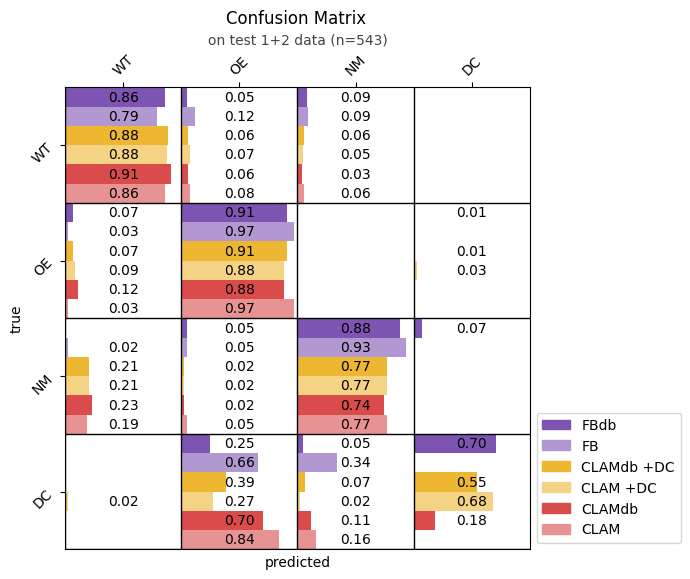

In [15]:
# Plot multi bar confusion matrix
data_name = "test+pathxl-100"
metric_name = "conf_matrix"
model_names = ["CLAM", "CLAM_db", "CLAM_m", "CLAM_db_m", "fb_spacing4", "fb_db_spacing4"]
model_name_mapping = {
        "CLAM":"CLAM",
        "CLAM_db":"CLAMdb",
        "CLAM_m":"CLAM +DC",
        "CLAM_db_m":"CLAMdb +DC",
        "fb_db_spacing4":"FBdb",
        "fb_spacing4":"FB",
    }
model_colors = {
        "CLAM":color_dict["r_p"],
        "CLAM_db":color_dict["r"],
        "CLAM_m":color_dict["y_p"],
        "CLAM_db_m":color_dict["y"],
        "fb_db_spacing4":color_dict["p"],
        "fb_spacing4":color_dict["p_p"],
    }
# Pick checkpoint with the highest accuracy on test
confusion_matrices = []
for model_name in model_names:
    best_checkpoint_idx = np.argmax([model_results["test"][model_name][checkpoint_name]["accuracy"] for checkpoint_name in model_results[data_name][model_name]])
    best_checkpoint_name = list(model_results[data_name][model_name].keys())[best_checkpoint_idx]
    confusion_matrices.append(model_results[data_name][model_name][best_checkpoint_name][metric_name])

std_confusion_matrices = None
# confusion_matrices = [model_visualizations[data_name][model_name][f"mean_{metric_name}"] for model_name in model_names]
# std_confusion_matrices = [model_visualizations[data_name][model_name][f"std_{metric_name}"] for model_name in model_names]
plot_multi_confusion_matrix(confusion_matrices, std_confusion_matrices, class_names=P53_CLASS_CODES,
    title=f"Confusion Matrix",
    subtitle=f"on test 1+2 data (n={len(get_labels(data_name))})",
    model_names=[model_name_mapping[model_name] for model_name in model_names],
    model_colors=[model_colors[model_name] for model_name in model_names],
    put_text=True,
    percentages=False,
    figsize=(6,6),
    save_path=os.path.join(RESULTS_DIR, "..", "images", f"confusion_matrix.png")
)

### Incorrect ones in common between best models

In [16]:
# For the best models, load the predictions for test+pathxl-100
data_name = "test+pathxl-100"
model_names = ["CLAM", "CLAM_db", "CLAM_m", "CLAM_db_m", "fb_spacing4", "fb_db_spacing4"]
model_name_mapping = {
        "CLAM":"CLAM",
        "CLAM_db":"CLAMdb",
        "CLAM_m":"CLAM +DC",
        "CLAM_db_m":"CLAMdb +DC",
        "fb_db_spacing4":"FBdb",
        "fb_spacing4":"FB",
    }
case_to_pred = {}
case_to_confidence = {}
model_accuracy = {}
for model_name in model_names:
    # Pick checkpoint that had the highest accuracy
    best_checkpoint_idx = np.argmax([model_results["test"][model_name][checkpoint_name]["accuracy"] for checkpoint_name in model_results[data_name][model_name]])
    best_checkpoint_name = list(model_results[data_name][model_name].keys())[best_checkpoint_idx]
    model_accuracy[model_name] = model_results[data_name][model_name][best_checkpoint_name]["accuracy"]

    results = load_results(model_name, data_name)
    labels = get_labels(data_name)
    case_names = list(set(results["status_probs"].keys()).intersection(labels.keys()))

    case_to_pred[model_name] = {}
    case_to_confidence[model_name] = {}

    for i, case in enumerate(P53_BOLERO.iterrows()):
        case_id = case[1]["Case ID"]
        status_prob = status_probs[i]
        case_to_pred[model_name][case_id] = np.argmax(status_prob)
        case_to_confidence[model_name][case_id] = np.max(status_prob)

color_mapping = {0:color_dict['g'], 1:color_dict['o'], 2:color_dict['b'], 3:color_dict['p']}

NameError: name 'P53_BOLERO' is not defined

### Effect of concordance in pathxl

Excluding 75 concordance anyway

In [17]:
# # For the pathxl results, check if the best models predictions correlated to the concordance between pathologists
# data_name = "pathxl"

# labels = pd.read_csv(os.path.join(BASE_DIR[data_name], 'labels.csv'))
# # idx is id column and biopsy_nr column separated by _
# labels["idx"] = labels["id"].astype(str) + "_" + labels["biopsy_nr"].astype(str)
# labels = labels.set_index("idx")
# # Sort by id primarily and biopsy_nr secondarily
# labels = labels.sort_values(by=["id", "biopsy_nr"])
# # Map label
# mapping = {"WT":0, "Overexpression":1, "Null":2, "Double clones":3}
# labels["label"] = labels["label"].map(mapping)
# # Filter out any concordance % < 75
# labels = labels[labels["concordance %"] >= 75]

# # Separate the labels into 75 concordance and 100 concordance
# labels_75 = labels[labels["concordance %"] == 75]
# labels_100 = labels[labels["concordance %"] == 100]
# # Print len
# print(f"75 concordance: {len(labels_75)}")
# print(f"100 concordance: {len(labels_100)}")

# # Show label distribution for both 75 and 100
# fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# for i, labels in enumerate([labels_75, labels_100]):
#     label_counts = labels["label"].value_counts()
#     axs[i].bar(range(4), label_counts)
#     axs[i].set_xticks(range(4))
#     axs[i].set_xticklabels(P53_CLASS_CODES)
#     axs[i].set_title(f"Label distribution {75 + i*25} concordance")
# plt.show()



# # For each model calculate the accuracy on the 75 concordance and 100 concordance
# data_name = "test+pathxl-100"
# model_conf_matrices = []
# for model_name in model_names:
#     print(f"\n{model_name}")
#     accuracies_75 = []
#     accuracies_100 = []
#     conf_matrices_75 = []
#     conf_matrices_100 = []
#     results = load_results(model_name, data_name)

#     best_checkpoint_idx = np.argmax([model_results['test'][model_name][checkpoint_name]["accuracy"] for checkpoint_name in model_results[data_name][model_name]])
#     best_checkpoint_name = list(model_results[data_name][model_name].keys())[best_checkpoint_idx]

#     for concor in [75, 100]:
#         labels = labels_75 if concor == 75 else labels_100
#         # for checkpoint_name in list(results["status_probs"].values())[0].keys():
#         for checkpoint_name in [best_checkpoint_name]:
            
#             status_probs = []
#             for img_name in labels.index:
#                 if img_name not in results["status_probs"]:
#                     continue
#                 status_probs.append(results["status_probs"][img_name][checkpoint_name][0])

#             status_probs = np.array(status_probs)
#             y_pred = np.argmax(status_probs, axis=1)
#             y_true = np.array([labels.loc[img_name]["label"] for img_name in labels.index if img_name in results["status_probs"]])
#             accuracy, conf_matrix, fpr, tpr, auc, mean_auc = calculate_metrics(y_true, y_pred, status_probs)
#             if concor == 75:
#                 accuracies_75.append(accuracy)
#                 conf_matrices_75.append(conf_matrix)
#             else:
#                 accuracies_100.append(accuracy)
#                 conf_matrices_100.append(conf_matrix)
                
#     print(f"75 concordance: {np.mean(accuracies_75):.3f} ({np.std(accuracies_75):.3f})")
#     print(f"100 concordance: {np.mean(accuracies_100):.3f} ({np.std(accuracies_100):.3f})")
#     model_conf_matrices.append({
#         "conf_matrix_75": conf_matrices_75[0],
#         "conf_matrix_100": conf_matrices_100[0],
#     })
    
# # Plot multi conf matrix
# for concor in [75, 100]:
#     confusion_matrices = [model["conf_matrix_75" if concor == 75 else "conf_matrix_100"] for model in model_conf_matrices]
#     # mean_conf_matrices = [np.mean(conf_matrices, axis=0) for conf_matrices in confusion_matrices]
#     std_conf_matrices = None
#     # std_conf_matrices = [np.std(conf_matrices, axis=0) for conf_matrices in confusion_matrices]
#     plot_multi_confusion_matrix(confusion_matrices, std_conf_matrices, class_names=P53_CLASS_CODES,
#         title=f"Confusion Matrix",
#         subtitle=f"on {concor} concordance data (n={len(labels_75) if concor == 75 else len(labels_100)})",
#         model_names=[model_name_mapping[model_name] for model_name in model_names],
#         model_colors=[model_colors[model_name] for model_name in model_names],
#         put_text=True,
#         percentages=False,
#         figsize=(6,6),
#         save_path=os.path.join(RESULTS_DIR, "..", "images", f"confusion_matrix_{concor}.png")
#     )

### ROC curves for the best models on test+pathxl

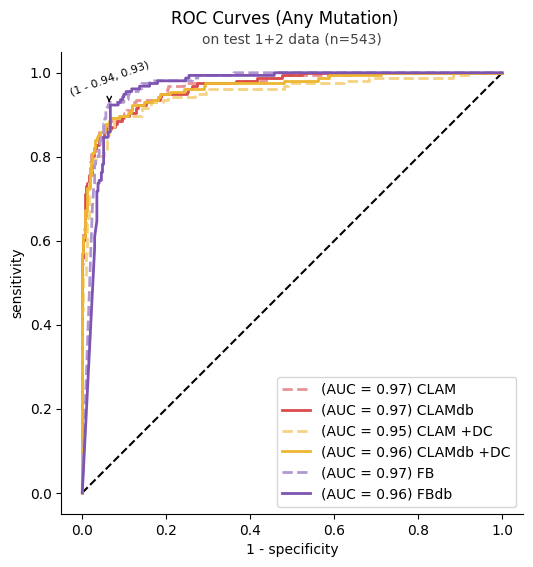

In [18]:
# Show the ROC curves of these models for the WT vs Mutated case
data_name = "test+pathxl-100"
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
closest_point_to_0_1 = (1,0)
closest_model = None
def dist_to_0_1(point):
    return np.sqrt((point[0]-0)**2 + (point[1]-1)**2)
for model_name in model_names:
    color = model_colors[model_name]

    best_checkpoint_idx = np.argmax([model_results["test"][model_name][checkpoint_name]["accuracy"] for checkpoint_name in model_results[data_name][model_name]])
    best_checkpoint_name = list(model_results[data_name][model_name].keys())[best_checkpoint_idx]
    fpr = model_results[data_name][model_name][best_checkpoint_name]["fpr_m"]
    tpr = model_results[data_name][model_name][best_checkpoint_name]["tpr_m"]
    AUC = model_results[data_name][model_name][best_checkpoint_name]["auc_m"]

    # AUC = model_visualizations[data_name][model_name]["max_auc_m"]
    # fpr = model_visualizations[data_name][model_name]["fpr_m"]
    # tpr = model_visualizations[data_name][model_name]["tpr_m"]
    plt.plot(fpr, tpr,
        color=color, alpha=1, linewidth=2,
        # label=f"{model_name_mapping[model_name]}{' '*(20-len(model_name_mapping[model_name]))}(AUC = {AUC:.2f})"
        label=f"(AUC = {AUC:.2f}) {model_name_mapping[model_name]}",
        linestyle='solid' if 'db' in model_name else 'dashed',
    )
    # Find the point closest to (0,1) for each model
    closest_point = min(zip(fpr, tpr), key=dist_to_0_1)
    if dist_to_0_1(closest_point) < dist_to_0_1(closest_point_to_0_1):
        closest_point_to_0_1 = closest_point
        closest_model = model_name    
plt.xlabel('1 - specificity')
plt.ylabel('sensitivity')
plt.suptitle(f'ROC Curves (Any Mutation)', fontsize=12, y=0.95)
# Add subtitle
plt.title(f'on test 1+2 data (n={len(get_labels(data_name))})', fontsize=10, color='#444444')
# Put legend reversed
plt.legend()
# Make x and y axis equal
plt.gca().set_aspect('equal', adjustable='box')

# Put a label on the point closest to (0,1)
plt.annotate(f"(1 - {1-closest_point_to_0_1[0]:.2f}, {closest_point_to_0_1[1]:.2f})", closest_point_to_0_1, 
    # Different arrowstyles are: '-', '->', '-[', '|-|', '-|>', '<-', '<->', '<|-', '<|-|>', 'fancy', 'simple', 'wedge'
    textcoords="offset points", xytext=(0,5), ha='center', color='black', fontsize=8, arrowprops=dict(arrowstyle='->', color='black'), rotation=20)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig(os.path.join(RESULTS_DIR, "..", "images", "roc_curves_am.png"), bbox_inches='tight')
plt.show()

# # Create a row of three subplots, each displaying a model pair of (CLAM, CLAM_db), (CLAM_m, CLAM_db_m), (fb_spacing4, fb_db_spacing4)
# # Each subplot will have two ROC curves, one for each of the two models in the pair
# data_name = "bolero"
# model_pairs = [("CLAM", "CLAM_db"), ("CLAM_m", "CLAM_db_m"), ("fb_spacing4", "fb_db_spacing4")]
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# for i, (model_name1, model_name2) in enumerate(model_pairs):
#     ax = axs[i]
#     closest_point_to_0_1 = (1,0)
#     closest_model = None
#     for model_name in [model_name1, model_name2]:
#         color = model_colors[model_name]

#         best_checkpoint_idx = np.argmax([model_results["test"][model_name][checkpoint_name]["accuracy"] for checkpoint_name in model_results[data_name][model_name]])
#         best_checkpoint_name = list(model_results[data_name][model_name].keys())[best_checkpoint_idx]
#         fpr = model_results[data_name][model_name][best_checkpoint_name]["fpr_m"]
#         tpr = model_results[data_name][model_name][best_checkpoint_name]["tpr_m"]
#         AUC = model_results[data_name][model_name][best_checkpoint_name]["auc_m"]

#         ax.plot(fpr, tpr, 
#                 label=f"(AUC = {AUC:.2f}) {model_name_mapping[model_name]}",
#             color=color, alpha=1, linewidth=2)
#         # Find the point closest to (0,1) for each model
#         closest_point = min(zip(fpr, tpr), key=dist_to_0_1)
#         if dist_to_0_1(closest_point) < dist_to_0_1(closest_point_to_0_1):
#             closest_point_to_0_1 = closest_point
#             closest_model = model_name
#     ax.plot([0, 1], [0, 1], 'k--')
#     ax.set_xlabel('1 - Specificity')
#     ax.set_ylabel('Sensitivity')
#     ax.set_title(f'ROC Curves for WT vs Mutated on {data_name}')
#     ax.legend()
#     # Make x and y axis equal
#     ax.set_aspect('equal', adjustable='box')

#     # Put a label on the point closest to (0,1)
#     ax.annotate(f"(1 - {1-closest_point_to_0_1[0]:.2f}, {closest_point_to_0_1[1]:.2f})", closest_point_to_0_1, 
#         textcoords="offset points", xytext=(10,-20), ha='left', color='black', fontsize=8, arrowprops=dict(arrowstyle='->', color='black'), rotation=0)
# plt.show()

### AUC per class (not very interesting, basically shows the same as the confusion matrix)

In [19]:
# Plot AUC per class comparison between these models
data_name = "test+pathxl"
metric_name = "auc_per_class"
auc_per_class = {}
std_auc_per_class = {}
for i in range(4): # The four classes
    auc_per_class[i]     = [model_visualizations[data_name][model_name][f"mean_{metric_name}"][i] for model_name in model_names]
    std_auc_per_class[i] = [model_visualizations[data_name][model_name][f"std_{metric_name}"][i] for model_name in model_names]


# fig, ax = plt.subplots(1, 1, figsize=(6,6))
# width = 1/len(confusion_matrices)
# class_names = P53_CLASS_CODES

# # Place grid lines at the cell boundaries
# for i in range(len(class_names)):
#     ax.axhline(i, color='k', linewidth=1)
# ax.set_yticks(np.arange(len(class_names))+0.5)
# ax.set_yticklabels(reversed(class_names), rotation=45)
# ax.set_ylim(0, len(class_names))
# # Place x ticks above the plot
# plt.xlabel('AUC')
# plt.ylabel('Class')
# plt.title('AUC per class')

# for i in range(len(class_names)):
#     cell_y = width/2 + len(class_names)-1-i
#     for k in range(len(confusion_matrices)):
#         bar_y = cell_y + width * k
#         # Plot rectangle as horizontal bar
#         color = model_colors[model_names[k]]
#         ax.barh(bar_y, auc_per_class[i][k].item(), width, left=0, color=color, alpha=1, xerr=std_auc_per_class[i][k].item(), error_kw=dict(ecolor='#444444', lw=1))
#         # Put the number in the center of the bar
#         num = auc_per_class[i][k].item()
#         num_str = f"{num:.2f} ± {std_auc_per_class[i][k].item():.2f}"
#         ax.text(0.01, bar_y, num_str, ha='left', va='center', color="black")

# if model_names is not None:
#     plt.legend(handles=[
#         plt.Rectangle((0,0),1,1, color=model_colors[model_names[i]], label=model_name_mapping[model_names[i]]) for i in reversed(range(len(model_names)))] +\
#         [plt.Line2D([0], [0], color='#444444', lw=1, label='std')],
#     # Place the legend outside the plot
#     loc='lower left', bbox_to_anchor=(1, 0))

# plt.show()

KeyError: 'mean_auc_per_class'

### comparison on BOLERO
#### BOLERO predictions

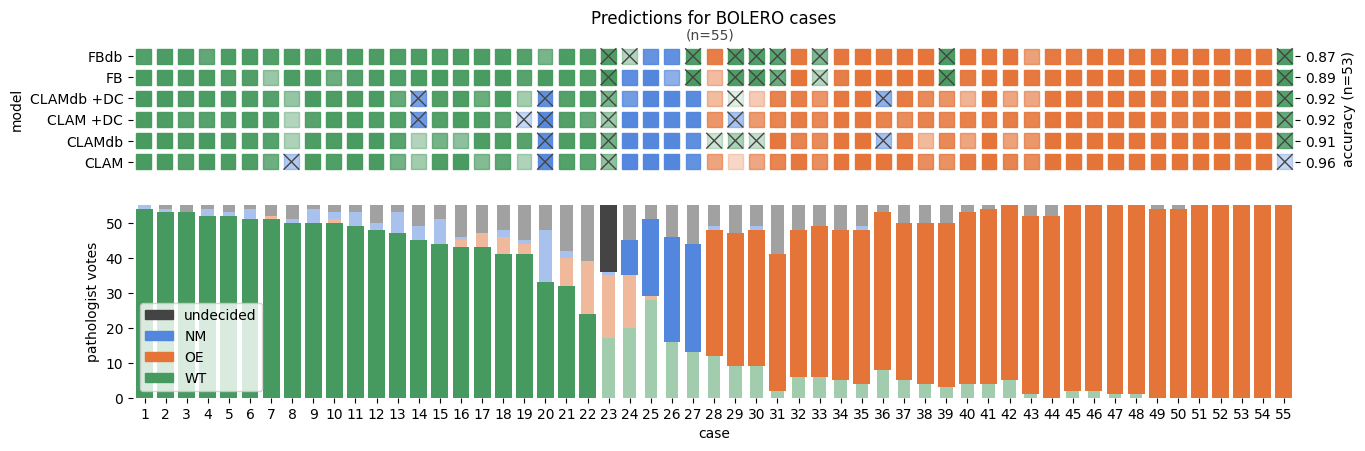

In [20]:
P53_BOLERO = pd.read_csv(os.path.join(BASE_DIR["bolero"], 'P53_BOLERO_T.csv'))
P53_BOLERO.sort_values('Case ID', inplace=True)
P53_BOLERO.reset_index(drop=True, inplace=True)

fig, axs = plt.subplots(2, 1, figsize=(10,10))

n_labels = 5
counts = np.zeros((len(P53_BOLERO), n_labels))
# For every case
for i, case in enumerate(P53_BOLERO.iterrows()):
    # Get the labels
    labels = case[1].values[1:-1] # Exclude Case ID and GS
    # For every label
    for j, label in enumerate(labels):
        # Increment the count
        counts[i, label] += 1
# Create a DataFrame
counts = pd.DataFrame(counts, columns=range(n_labels))
# Sort by custom ordering (it contains case IDs, not indices of the DataFrame)
# case_nr_custom_ordering = ['RB0024', 'RB0020', 'RB0011', 'RB0003', 'RB0042', 'RB0051', 'RB0030', 'RB0027', 'RB0053', 'RB0032', 'RB0043', 'RB0015', 'RB0019', 'RB0006', 'RB0033', 'RB0046', 'RB0017', 'RB0031', 'RB0038', 'RB0029', 'RB0022', 'RB0040', 'RB0045', 'RB0047', 'RB0028', 'RB0054', 'RB0035', 'RB0050', 'RB0044', 'RB0009', 'RB0014', 'RB0013', 'RB0036', 'RB0037', 'RB0010', 'RB0005', 'RB0052', 'RB0039', 'RB0004', 'RB0007', 'RB0034', 'RB0049', 'RB0008', 'RB0002', 'RB0023', 'RB0026', 'RB0016', 'RB0001', 'RB0055', 'RB0012', 'RB0018', 'RB0025', 'RB0041', 'RB0048', 'RB0021']
case_nr_custom_ordering = ['RB0024', 'RB0020', 'RB0011', 'RB0003', 'RB0042', 'RB0030', 'RB0051', 'RB0027', 'RB0032', 'RB0053', 'RB0043', 'RB0015', 'RB0019', 'RB0006', 'RB0033', 'RB0046', 'RB0017', 'RB0038', 'RB0031', 'RB0029', 'RB0022', 'RB0040', 'RB0028', 'RB0047', 'RB0045', 'RB0054', 'RB0035', 'RB0050', 'RB0044', 'RB0009', 'RB0049', 'RB0013', 'RB0036', 'RB0037', 'RB0052', 'RB0014', 'RB0010', 'RB0039', 'RB0034', 'RB0004', 'RB0007', 'RB0005', 'RB0023', 'RB0001', 'RB0002', 'RB0008', 'RB0026', 'RB0016', 'RB0012', 'RB0055', 'RB0018', 'RB0041', 'RB0048', 'RB0025', 'RB0021']
index_ordering = [P53_BOLERO['Case ID'].tolist().index(case_id) for case_id in case_nr_custom_ordering]
counts = counts.iloc[index_ordering]
# More satisfying versions of these colors
# color = ['grey','#2ca02c','#ff7f0e','#1f77b4','#444444']
color = ['grey', color_dict['g'], color_dict['o'], color_dict['b'], '#444444']
labels = ['missing', 'WT', 'OE', 'NM', 'undecided']
ax = counts.plot(kind='bar', stacked=True, figsize=(15,5), width=.6, color=color, alpha=.5, ax=axs[1])

# Add legend with the labels
plt.legend(handles=[
    plt.Rectangle((0,0),1,1, color=color[i+1], label=labels[i+1]) for i in reversed(range(n_labels-1))],
    loc='lower left')
ax.set_xticks(np.arange(len(counts)), np.arange(1, len(counts)+1), rotation=0)

# Draw the bar that corresponds to the GS for each case in a more saturated color
GS = P53_BOLERO['GS'].copy()
GS = GS.loc[counts.index]
for i in range(len(GS)):
    GS_label = GS.iloc[i]
    bar_widths = counts.iloc[i].values
    bar_widths_cumsum = bar_widths.cumsum()
    left = bar_widths_cumsum[GS_label] - bar_widths[GS_label]
    ax.bar(i, bar_widths[GS_label], bottom=left, color=color[GS_label])

ax.set_xlabel('case')
ax.set_ylabel('pathologist votes')
# ax.set_title('Distributions of ratings for P53')
ax.set_ylim(0, max(counts.sum(axis=1)))




# For the best models, print the predictions for each BOLERO case
data_name = "bolero"
model_names = ["CLAM", "CLAM_db", "CLAM_m", "CLAM_db_m", "fb_spacing4", "fb_db_spacing4"]
model_name_mapping = {
        "CLAM":"CLAM",
        "CLAM_db":"CLAMdb",
        "CLAM_m":"CLAM +DC",
        "CLAM_db_m":"CLAMdb +DC",
        "fb_db_spacing4":"FBdb",
        "fb_spacing4":"FB",
    }
case_to_pred = {}
case_to_confidence = {}
model_accuracy = {}
y_true_in_order = [P53_BOLERO.loc[P53_BOLERO['Case ID'] == case_id, 'GS'].values[0] for case_id in case_nr_custom_ordering]
y_true_in_order = [y-1 if y != 4 else 4 for y in y_true_in_order]
for model_name in model_names:
    # Pick checkpoint that had the highest accuracy
    best_checkpoint_idx = np.argmax([model_results["test"][model_name][checkpoint_name]["accuracy"] for checkpoint_name in model_results[data_name][model_name]])
    best_checkpoint_name = list(model_results[data_name][model_name].keys())[best_checkpoint_idx]
    model_accuracy[model_name] = model_results[data_name][model_name][best_checkpoint_name]["accuracy"]

    results = load_results(model_name, data_name)
    slide_names = [int(slide_name) for slide_name in get_labels(data_name).keys()]
    status_probs = get_status_probs_for_bolero(results, slide_names, best_checkpoint_name)

    case_to_pred[model_name] = {}
    case_to_confidence[model_name] = {}

    for i, case in enumerate(P53_BOLERO.iterrows()):
        case_id = case[1]["Case ID"]
        status_prob = status_probs[i]
        case_to_pred[model_name][case_id] = np.argmax(status_prob)
        case_to_confidence[model_name][case_id] = np.max(status_prob)

    # Sort case_to_pred by case_nr_custom_ordering
    case_to_pred[model_name] = {case_id: case_to_pred[model_name][case_id] for case_id in case_nr_custom_ordering}
    case_to_confidence[model_name] = {case_id: case_to_confidence[model_name][case_id] for case_id in case_nr_custom_ordering}

color_mapping = {0:color_dict['g'], 1:color_dict['o'], 2:color_dict['b']}

# Plot the predictions for each model in a grid of n_models x 55 using squares in the color from the color mapping
ax = axs[0]
for i, model_name in enumerate(model_names):
    for j, case_id in enumerate(case_nr_custom_ordering):
        color = color_mapping[case_to_pred[model_name][case_id]]
        ax.add_patch(plt.Rectangle((j+.15, i+.15), .7, .7, color=color, alpha=case_to_confidence[model_name][case_id]**2))
        # Put a black x in the middle if the pred was wrong
        if case_to_pred[model_name][case_id] != y_true_in_order[j]:
            ax.plot([j+.15, j+.85], [i+.15, i+.85], color='#444444', linewidth=1)
            ax.plot([j+.15, j+.85], [i+.85, i+.15], color='#444444', linewidth=1)
# ax.set_xticks(np.arange(len(case_nr_custom_ordering))+0.5, np.arange(len(case_nr_custom_ordering))+1)
ax.set_xticks([])
ax.set_yticks(np.arange(len(model_names))+0.5, [model_name_mapping[model_name] for model_name in model_names])
ax.set_ylabel('model')
# ax.set_xlabel('case')
ax.set_title('Predictions for BOLERO cases', y=.9)
plt.suptitle('(n=55)', fontsize=10, y=.85, x=0.51, color='#444444')
# Make x and y axis equal
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(0, len(case_nr_custom_ordering))

# Make another y-axis on the right
ax2 = ax.twinx()
ax2.set_aspect('equal')
ax2.set_yticks(np.arange(len(model_names))+0.5,
    # Each models accuracy on BOLERO
    [f"{model_accuracy[model_name]:.2f}" for model_name in model_names])
ax2.set_ylabel('accuracy (n=53)')
ax2.set_ylim(0, len(model_names))

# Decrease the distance between the two subplots
plt.subplots_adjust(hspace=0)

# Remove the box around the subplot
for direction in ['top', 'right', 'bottom', 'left']:
    axs[1].spines[direction].set_visible(False)
    ax.spines[direction].set_visible(False)
    ax2.spines[direction].set_visible(False)

plt.show()


In [21]:
# Print all case ids from P53_BOLERO
print("Case IDs for BOLERO:")

ORDERED = P53_BOLERO.copy()
ORDERED['n_1s'] = ORDERED.apply(lambda row: (row.values == 1).sum(), axis=1)
ORDERED['n_2s'] = ORDERED.apply(lambda row: (row.values == 2).sum(), axis=1)
ORDERED['n_3s'] = ORDERED.apply(lambda row: (row.values == 3).sum(), axis=1)
ORDERED['n_4s'] = ORDERED.apply(lambda row: (row.values == 4).sum(), axis=1)
ORDERED.sort_values('n_4s', ascending=False, inplace=True)
ORDERED.sort_values('n_1s', ascending=False, inplace=True)

WT_CASES = ORDERED[ORDERED['GS'] == 1].copy()
WT_CASES.sort_values('n_1s', ascending=False, inplace=True)
OE_CASES = ORDERED[ORDERED['GS'] == 2].copy()
OE_CASES.sort_values('n_2s', ascending=True, inplace=True)
NM_CASES = ORDERED[ORDERED['GS'] == 3].copy()
NM_CASES.sort_values('n_3s', ascending=True, inplace=True)
EQ_CASES = ORDERED[ORDERED['GS'] == 4].copy()
print(EQ_CASES["Case ID"])

# Now concatenate these
ORDERED = pd.concat([WT_CASES, EQ_CASES, NM_CASES, OE_CASES])

case_ids = ORDERED['Case ID'].values
print(case_ids.tolist())

Case IDs for BOLERO:
27    RB0028
Name: Case ID, dtype: object
['RB0024', 'RB0020', 'RB0011', 'RB0003', 'RB0042', 'RB0030', 'RB0051', 'RB0027', 'RB0032', 'RB0053', 'RB0043', 'RB0015', 'RB0019', 'RB0006', 'RB0033', 'RB0046', 'RB0017', 'RB0038', 'RB0031', 'RB0029', 'RB0022', 'RB0040', 'RB0028', 'RB0047', 'RB0045', 'RB0054', 'RB0035', 'RB0050', 'RB0044', 'RB0009', 'RB0049', 'RB0013', 'RB0036', 'RB0037', 'RB0052', 'RB0014', 'RB0010', 'RB0039', 'RB0034', 'RB0004', 'RB0007', 'RB0005', 'RB0023', 'RB0001', 'RB0002', 'RB0008', 'RB0026', 'RB0016', 'RB0012', 'RB0055', 'RB0018', 'RB0021', 'RB0041', 'RB0048', 'RB0025']


confidence (but this information is already kind of in the ROC curves?)

In [22]:
# Calculate for each model what the confidence was for cases they got correct, and cases they got wrong
# Plot this in a horizontal barchart
plt.figure(figsize=(6,4))
bar_width = 0.4
for i, model_name in enumerate(model_names):
    correct_confidence = []
    false_confidence = []
    for case_id in case_nr_custom_ordering:
        if case_to_pred[model_name][case_id] == y_true_in_order[case_nr_custom_ordering.index(case_id)]:
            correct_confidence.append(case_to_confidence[model_name][case_id])
        else:
            false_confidence.append(case_to_confidence[model_name][case_id])
    # print(f"{model_name}:")
    # print(f"Correct confidence: {np.mean(correct_confidence):.2f} ± {np.std(correct_confidence):.2f}")
    # print(f"False confidence: {np.mean(false_confidence):.2f} ± {np.std(false_confidence):.2f}")

#     plt.barh(i, np.mean(correct_confidence), xerr=np.std(correct_confidence), color=color_dict['g'], alpha=1, height=bar_width)
#     plt.text(0.1, i, f"{np.mean(correct_confidence):.2f} ± {np.std(correct_confidence):.2f}", ha='left', va='center', color='black')
#     plt.barh(i+0.4, np.mean(false_confidence), xerr=np.std(false_confidence), color=color_dict['r'], alpha=1, height=bar_width)
#     plt.text(0.05, i+0.4, f"{np.mean(false_confidence):.2f} ± {np.std(false_confidence):.2f}", ha='left', va='center', color='black')
# plt.xlabel('confidence')
# plt.ylabel('model')
# plt.title('Confidence for correct and false predictions')
# plt.yticks(np.arange(len(model_names))+0.2, [model_name_mapping[model_name] for model_name in model_names])
# plt.show()

<Figure size 600x400 with 0 Axes>

#### comparison to BOLERO pathologists

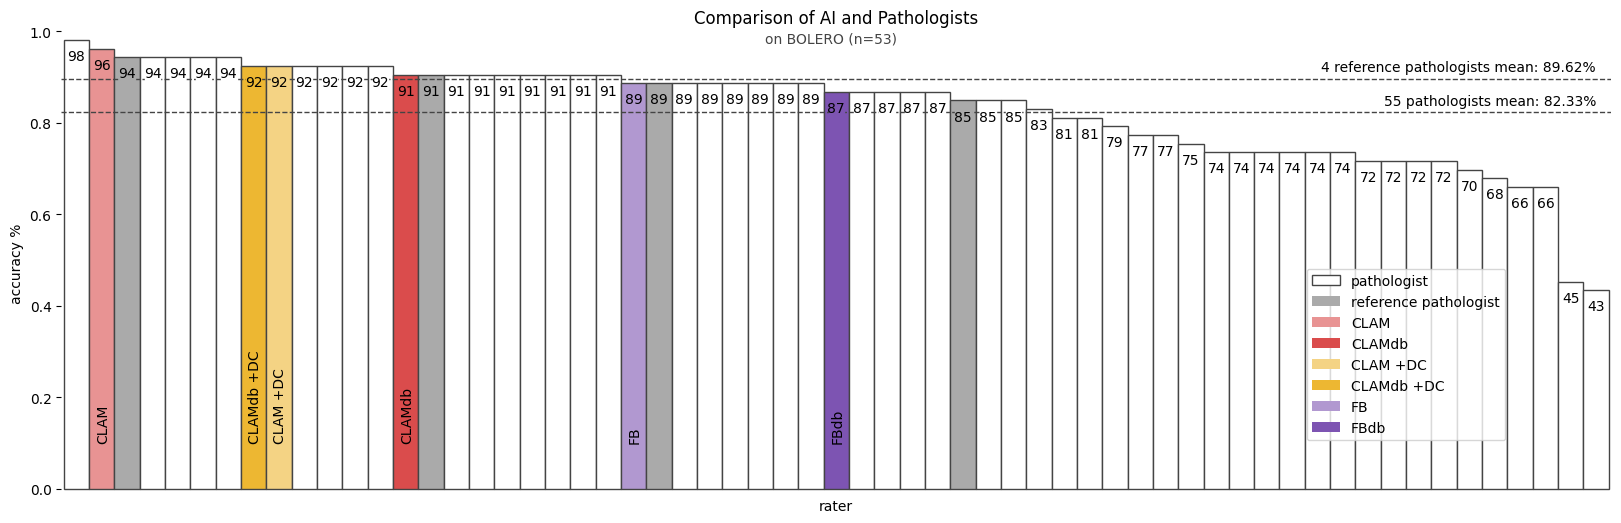

In [23]:
raters = P53_BOLERO.columns[1:-1]

# For every rater, calculate the agreement with the consensus (without the rater)
agreement = {}
for rater in raters:
    without_equiv = P53_BOLERO[P53_BOLERO['GS'] != 4]
    # Skip Case ID RB0021
    without_equiv = without_equiv[without_equiv['Case ID'] != 'RB0021']
    agreement[rater] = without_equiv.apply(lambda x: x[rater] == x['GS'], axis=1).sum() / len(without_equiv)

agreement = pd.Series(agreement)
pathologist_accuracy = agreement.mean()
reference_pathologists = ["BOLERO - SM", "BOLERO - KS", "BOLERO - MJ", "BOLERO - JO"]
# Nudge reference pathologist accuracy up by epsilon to sort them to the front if equal
agreement[reference_pathologists] = agreement[reference_pathologists] + 1e-7

# Insert AI models
for model_name in model_names:
    acc = model_accuracy[model_name]
    agreement[model_name] = acc + 1e-6

agreement = agreement.sort_values(ascending=False)

# Plot bar chart of agreement
plt.figure(figsize=(20,6))
ax = agreement.plot(kind='bar', width=1, 
    # color=color_dict["b_p"]
    # Make bars white with black border
    facecolor='white', edgecolor='#444444',
)

# PATHOLOGIST LINES
# Put horizontal black dashed line at median/mean of pathologists
ax.axhline(pathologist_accuracy, color='#444444', linestyle='dashed', linewidth=1)
# Put text on top of line
ax.text(len(agreement)-1, pathologist_accuracy+0.01, f"55 pathologists mean: {pathologist_accuracy*100:.2f}%", ha='right', va='bottom')
# Also put dashed line at mean of reference pathologists
ref_pat_accuracy = agreement[reference_pathologists].mean()
ax.axhline(ref_pat_accuracy, color='#444444', linestyle='dashed', linewidth=1)
ax.text(len(agreement)-1, ref_pat_accuracy+0.01, f"4 reference pathologists mean: {ref_pat_accuracy*100:.2f}%", ha='right', va='bottom')

plt.xticks([])
plt.ylabel('accuracy %')
plt.xlabel('rater')
plt.title('Comparison of AI and Pathologists')
plt.suptitle('on BOLERO (n=53)', fontsize=10, y=0.88, x=0.51, color='#444444')
# Show text on the bars
for i in range(len(agreement)):
    # Put square behind the text for contrast
    patch_color = "white"
    if agreement.index[i] in reference_pathologists:
        patch_color = "#aaaaaa"
    elif agreement.index[i] in model_names:
        patch_color = model_colors[model_names[model_names.index(agreement.index[i])]]
    ax.add_patch(plt.Rectangle((i-0.3, agreement.iloc[i]-.05), .6, .03, color=patch_color, zorder=3))
    ax.text(i, agreement.iloc[i]-0.02, round(agreement.iloc[i]*100), ha='center', va='top')
    # plt.text(i, 0.01, round(agreement.iloc[i]*100), ha='center', va='bottom')
# Make reference pathologist bars different color
for ref_pat in reference_pathologists:
    ref_pat_x = agreement.index.get_loc(ref_pat)
    plt.gca().get_children()[ref_pat_x].set_facecolor("#aaaaaa")

# Make AI bars their own color
for model_name in model_names:
    model_x = agreement.index.get_loc(model_name)
    plt.gca().get_children()[model_x].set_facecolor(model_colors[model_name])
    # Put rotated 90 text on the bar with name
    plt.text(model_x+0.05, 0.1, model_name_mapping[model_name], ha='center', va='bottom', rotation=90)

plt.xlim(-.6, len(agreement)-.4)
plt.ylim(-0.01, 1)

plt.legend(handles=[
        plt.Rectangle((0,0),1,1, facecolor="white", edgecolor="#444444", label='pathologist'),
        plt.Rectangle((0,0),1,1, facecolor="#aaaaaa", label='reference pathologist')] +\
        [plt.Rectangle((0,0),1,1, facecolor=model_colors[model_name], label=model_name_mapping[model_name]) for model_name in model_names],
    loc='lower left', bbox_to_anchor=(0.799, 0.1)
)

# Remove box around plot
for direction in ['top', 'right', 'bottom', 'left']:
    plt.gca().spines[direction].set_visible(False)

plt.savefig(os.path.join(RESULTS_DIR, "..", "images", "ai-vs-pathologist.png"), bbox_inches='tight')
plt.show()

#### ROC curves + comparison to BOLERO pathologists

CLAM outperforms 37 raters
CLAMdb outperforms 32 raters
CLAM +DC outperforms 37 raters
CLAMdb +DC outperforms 37 raters
FB outperforms 15 raters
FBdb outperforms 18 raters


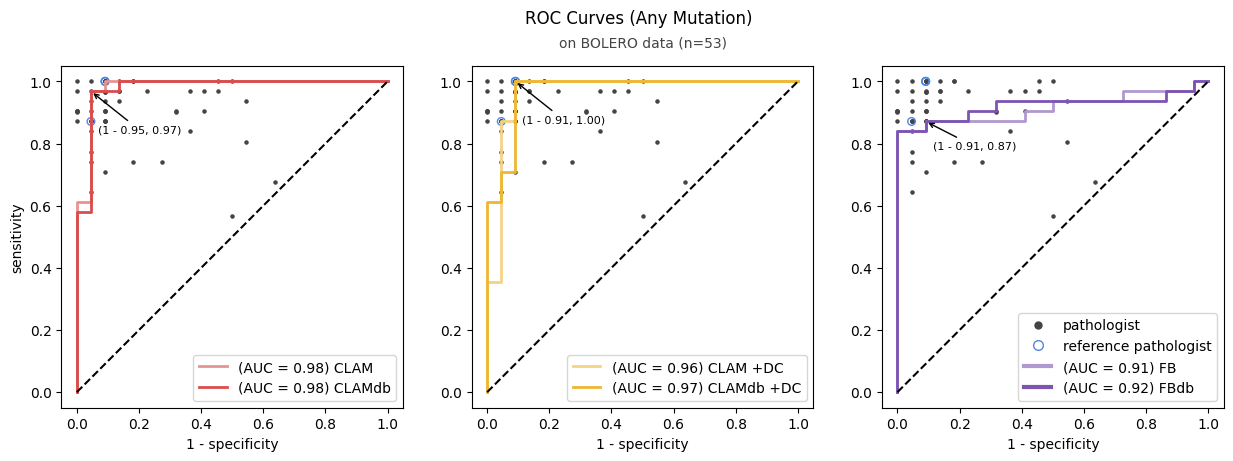

In [35]:
# For each pathologist calculate the specificity and sensitivity
sensitivity = {}
specificity = {}
for rater in raters:
    TP = without_equiv[(without_equiv['GS'] > 1) & (without_equiv[rater] > 1)].shape[0]
    TN = without_equiv[(without_equiv['GS'] == 1) & (without_equiv[rater] == 1)].shape[0]
    FP = without_equiv[(without_equiv['GS'] == 1) & (without_equiv[rater] > 1)].shape[0]
    FN = without_equiv[(without_equiv['GS'] > 1) & (without_equiv[rater] == 1)].shape[0]
    sensitivity[rater] = TP / (TP + FN)
    specificity[rater] = TN / (TN + FP)

# Create a row of three subplots, each displaying a model pair of (CLAM, CLAM_db), (CLAM_m, CLAM_db_m), (fb_spacing4, fb_db_spacing4)
# Each subplot will have two ROC curves, one for each of the two models in the pair
data_name = "bolero"
model_pairs = [("CLAM", "CLAM_db"), ("CLAM_m", "CLAM_db_m"), ("fb_spacing4", "fb_db_spacing4")]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, (model_name1, model_name2) in enumerate(model_pairs):
    ax = axs[i]
    closest_point_to_0_1 = (1,0)
    closest_model = None
    outperformed = 0
    outperformed_by = 0
    legend_handles = [
        plt.Line2D([0], [0], color='#444444', marker='o', markersize=5, label='pathologist', linewidth=0),
        plt.Line2D([0], [0], color=color_dict['b'], marker='o', markersize=7, markerfacecolor='none', label='reference pathologist', linewidth=0)]
    for model_name in [model_name1, model_name2]:
        color = model_colors[model_name]

        best_checkpoint_idx = np.argmax([model_results["test"][model_name][checkpoint_name]["accuracy"] for checkpoint_name in model_results[data_name][model_name]])
        best_checkpoint_name = list(model_results[data_name][model_name].keys())[best_checkpoint_idx]
        fpr = model_results[data_name][model_name][best_checkpoint_name]["fpr_m"]
        tpr = model_results[data_name][model_name][best_checkpoint_name]["tpr_m"]
        AUC = model_results[data_name][model_name][best_checkpoint_name]["auc_m"]

        ax.plot(fpr, tpr, 
                label=f"(AUC = {AUC:.2f}) {model_name_mapping[model_name]}",
            color=color, alpha=1, linewidth=2)
        # Find the point closest to (0,1) for each model
        closest_point = min(zip(fpr, tpr), key=dist_to_0_1)
        if dist_to_0_1(closest_point) < dist_to_0_1(closest_point_to_0_1):
            closest_point_to_0_1 = closest_point
            closest_model = model_name

        legend_handles.append(plt.Line2D([0], [0], color=color, label=f"(AUC = {AUC:.2f}) {model_name_mapping[model_name]}", linewidth=3))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('1 - specificity')
    axs[0].set_ylabel('sensitivity')
    # ax.set_title(f'ROC Curves for WT vs Mutated on {data_name}')
    ax.legend()
    # Make x and y axis equal
    ax.set_aspect('equal', adjustable='box')

    # Put a label on the point closest to (0,1)
    xy_text = (5,-30) if i in [0,1] else (5,-20)
    ax.annotate(f"(1 - {1-closest_point_to_0_1[0]:.2f}, {closest_point_to_0_1[1]:.2f})", closest_point_to_0_1, 
        textcoords="offset points", xytext=xy_text, ha='left', color='black', fontsize=8, arrowprops=dict(arrowstyle='->', color='black'), rotation=0)

    # Put dot for each rater
    # Seed random number generator for reproducibility
    np.random.seed(42)
    for rater in raters:
        sens = sensitivity[rater]
        spec = specificity[rater]
        x, y = 1-spec, sens
        # # Add small perturbation to make sure the dots don't overlap
        # perturbation = 0.005
        # x = 1-spec + np.random.uniform(-perturbation, perturbation)
        # y = sens + np.random.uniform(-perturbation, perturbation)
        # white dot with #444444 edge
        ax.scatter(x, y, color='#444444', edgecolor='#444444', s=5)
    for ref_rater in reference_pathologists:
        sens = sensitivity[ref_rater]
        spec = specificity[ref_rater]
        # grey dot with #444444 edge
        ax.scatter(1-spec, sens, edgecolor=color_dict["b"], s=30, facecolor='none')

    plt.legend(handles=legend_handles)

    # Calculate how many pathologists are strictly outperformed by the model based on the ROC curve
    for model_name in [model_name1, model_name2]:
        best_checkpoint_idx = np.argmax([model_results["test"][model_name][checkpoint_name]["accuracy"] for checkpoint_name in model_results[data_name][model_name]])
        best_checkpoint_name = list(model_results[data_name][model_name].keys())[best_checkpoint_idx]
        fpr = model_results[data_name][model_name][best_checkpoint_name]["fpr_m"]
        tpr = model_results[data_name][model_name][best_checkpoint_name]["tpr_m"]

        outperformed = 0
        outperformed_by = 0
        for rater in raters:
            sens = sensitivity[rater]
            spec = specificity[rater]
            fp = 1-spec
            # If there is a point on the ROC curve that is strictly above the point for the rater, the model outperforms the rater
            if any([(tpr[i] >= sens and fpr[i] < fp) or (tpr[i] > sens and fpr[i] <= fp) for i in range(len(fpr))]):
                outperformed += 1
            # If every point on the ROC curve is strictly below the point for the rater, the model is outperformed by the rater
            elif all([(tpr[i] <= sens and fpr[i] > fp) or (tpr[i] < sens and fpr[i] >= fp) for i in range(len(fpr))]):
                outperformed_by += 1
                # This is kinda silly because only a perfect rater would strictly outperform ANY ROC curve

        print(f"{model_name_mapping[model_name]} outperforms {outperformed} raters")

plt.suptitle("ROC Curves (Any Mutation)", y=.95, x=.51)
# Add another supertitle
axs[1].set_title(f'on BOLERO data (n={len(without_equiv)})', fontsize=10, color='#444444', y=1.03)

plt.show()

## Spacing comparison

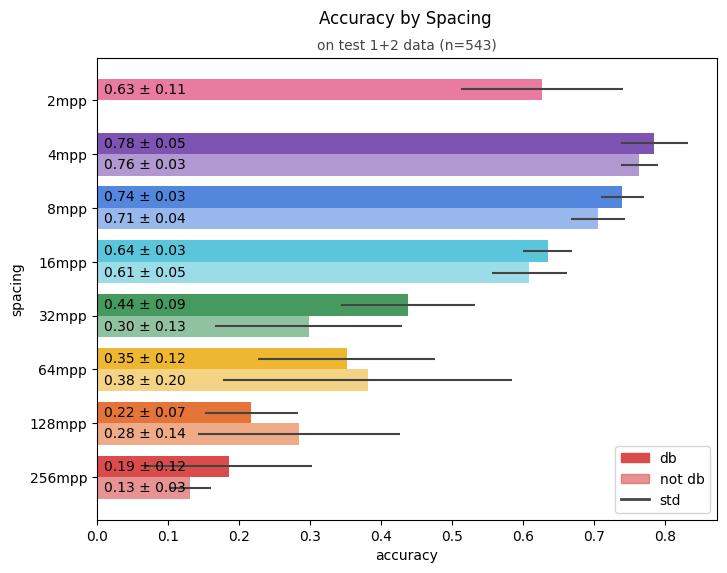

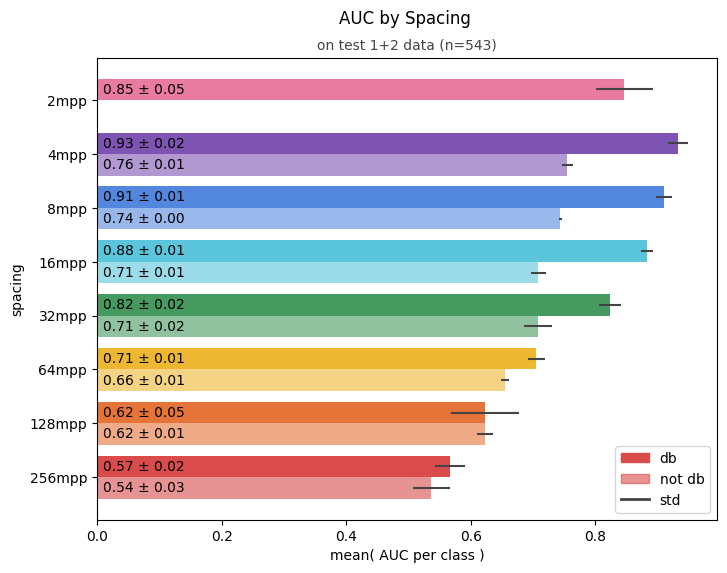

In [1141]:
# Plot horizontal barchart of accuracy, of only the fb models, sorted by spacing
data_name = "test+pathxl-100"
data_len = len(get_labels(data_name))
kwargs = {
    "accuracy": {"title": "Accuracy by Spacing", "subtitle": f"on test 1+2 data (n={data_len})", "xlabel": "accuracy"},
    "auc": {"title": "AUC by Spacing", "subtitle": f"on test 1+2 data (n={data_len})", "xlabel": "mean( AUC per class )"},
    }
for metric_name in ["accuracy", "auc"]:
    model_names = [model_name for model_name in model_visualizations[data_name] if "fb" in model_name]
    # First sort by whether it's db or not, then by spacing
    model_names = sorted(model_names, key=lambda x: "db" in x)
    model_names = sorted(model_names, key=lambda x: model_kwargs[x]["spacing"], reverse=True)
    metrics     = [model_visualizations[data_name][model_name][f"mean_{metric_name}"] for model_name in model_names]
    std_metrics = [model_visualizations[data_name][model_name][f"std_{metric_name}"] for model_name in model_names]

    model_names.insert(-1, "fb_spacing2")
    metrics.insert(-1, 0)
    std_metrics.insert(-1, 0)

    # Each spacing has a non-db and a db model, group these together in pairs of two, with the same color
    plt.figure(
        figsize=(8,6)
        )
    bar_width = 0.8
    for i, (model_name, metric, std_metric) in enumerate(zip(model_names, metrics, std_metrics)):
        if i % 2 == 0:
            color = colors[i//2]
        alpha = 1
        y = i - 0.1
        if "db" not in model_name:
            alpha = 0.6
            y += 0.2
        plt.barh(y, metric, xerr=std_metric, color=color, alpha=alpha, label=model_name, height=bar_width,
            error_kw=dict(ecolor='#444444'))
        # Put the number in the center of the bar
        if metric > 0:
            # plt.text(metric/2, y, f"{metric:.2f} ± {std_metric:.2f}", 
            #          ha='center', va='center', color="black")
            plt.text(0.01, y, f"{metric:.2f} ± {std_metric:.2f}", 
                     ha='left', va='center', color="black")
    plt.yticks(np.arange(len(model_names)//2)*2+0.5, [model_name.split('spacing')[-1]+"mpp" for model_name in model_names][::2])
    plt.xlabel(kwargs[metric_name]["xlabel"])
    plt.suptitle(kwargs[metric_name]["title"], fontsize=12, y=.96, x=.51)
    plt.title(kwargs[metric_name]["subtitle"], fontsize=10, color='#444444')
    plt.ylabel("spacing")
    # Put custom legend that only says db has brighter colors (with color 0 as example) and the black stripes are std
    plt.legend(handles=[
        plt.Rectangle((0,0),1,1, color=colors[0], alpha=1, label="db"),
        plt.Rectangle((0,0),1,1, color=colors[0], alpha=0.6, label="not db"),
        # Black line for std
        plt.Line2D([0], [0], color='#444444', lw=2, label='std')
    ], loc='lower right')
    plt.show()